

The bootstrap chain ladder is a statistical technique used in actuarial reserving to project future claim liabilities based on historical data. It builds upon the chain ladder method, but the chain ladder method by itself does not provide a measure of the uncertainty in its projections, which is where the bootstrap technique comes in. The bootstrap chain ladder provides an empirical distribution of reserve estimates, which can be used to quantify the uncertainty and variability around the estimates generated by the chain ladder.

The bootstrap chain ladder works by repeatedly resampling residuals from the original chain ladder model and creating a series of simulated datasets, each of which mimics the original data in its pattern of claims development. The most commonly used approach was originally outlined by England and Verrall in [*Stochastic Claims Reserving in General Insurance*](https://www.actuaries.org.uk/system/files/documents/pdf/sm0201.pdf), which notably described a technique that can be used to incorporate process variance, allowing for the quantification of the full prediction error of the total needed reserve. 

The bootstrap chain ladder is simple from a technical standpoint, but it is worth highlighting the DataFrame operations required to implement the full algorithm. The code used here leverages the Pandas library, but a future post will reproduce the full estimator pipeline using Polars. 

Much of what follows is a direct implementation of Appendix 3 from *Two Approaches to Calculating Correlated Reserve Indications Across Multiple Lines of Business*, Kirshner, et. al. Also, many of the DataFrame operations exhibited here can be implemented more efficiently, but the goal of this article was to present the bootstrap chain ladder with maximal clarity rather than focusing on optimal performance.


The steps to perform the bootstrap chain ladder:

1. Transform loss data into cumulative triangle representation.

2. Calculate all-year volume weighted age-to-age factors. 

3. Calculate the cumulative fitted triangle by applying backwards recursion, beginning with the observed cumulative losses from the latest diagonal.

4. Calculate the unscaled Pearson residuals, $r_{p}$, degrees of freedom $DF$ and scale parameter $\phi$.

5. Calculate the adjusted Pearson residuals, defined as $r_{p}^{{adj}} = \sqrt{\frac{n}{DF}} \times r_{p}$.

6. For each bootstrap sample (1...1000):

    i. Generate a sample from the adjusted Pearson residuals $r_{p}^{{adj}}$ with replacement.

    ii. Using the sampled adjusted Pearson residuals and fitted incremental triangle $m$, construct the triangle of sampled incremental losses
    $I_{i} = m + \hat{r}_{p}^{adj} \sqrt{m}$, where $\hat{r}_{p}^{adj}$ represents a sample with replacement from the adjusted Pearson residuals and $m$ the fitted incremental triangle.

    iii. Create a cumulative triangle using the result from ii., and project future losses using the chain ladder method. 

    iv. Incorporate process variance by simulating each future projected incremental loss from a gamma distribution parameterized with mean equal to the projected loss value and variance the loss value times $\phi$.

    v. Cumulate the incremental losses, then compute the total needed reserve as the ultimate projected value minus the latest cumulative loss amount by origin period.


7. Compute desired quantiles of interest from predictive distribution of bootstrap samples.

<br>


In what follows each step is demonstrated, along with exhibits to visually assess the distribution of future losses.



In [1]:

%load_ext watermark

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.set_printoptions(suppress=True, precision=5)
pd.set_option("display.precision", 5)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
warnings.simplefilter(action="ignore", category=FutureWarning)

%watermark --python --conda --hostname --machine --iversions


Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.28.0

conda environment: py311

Compiler    : MSC v.1941 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 170 Stepping 4, GenuineIntel
CPU cores   : 22
Architecture: 64bit

Hostname: JTRIZPC11

numpy     : 2.1.0
pandas    : 2.2.2
matplotlib: 3.9.2





Begin by loading the data from GitHub and transforming it into an incremental triangle:

In [2]:

# Load RAA dataset. 
dfraa = pd.read_csv("https://gist.githubusercontent.com/jtrive84/976c80786a6e97cce7483e306562f85b/raw/06a5c8b1f823fbe2b6da15f90a672517fa5b4571/RAA.csv")
dfraa = dfraa.sort_values(by=["ORIGIN", "DEV"])
tri0 = dfraa.pivot(index="ORIGIN", columns="DEV").rename_axis(None)
tri0.columns = tri0.columns.droplevel(0)
tri0.columns.name = None

print("Original incremental loss triangle:")

tri0


Original incremental loss triangle:


,1,2,3,4,5,6,7,8,9,10
1981,5012.0,3257.0,2638.0,898.0,1734.0,2642.0,1828.0,599.0,54.0,172.0
1982,106.0,4179.0,1111.0,5270.0,3116.0,1817.0,-103.0,673.0,535.0,NaN
1983,3410.0,5582.0,4881.0,2268.0,2594.0,3479.0,649.0,603.0,NaN,NaN
1984,5655.0,5900.0,4211.0,5500.0,2159.0,2658.0,984.0,NaN,NaN,NaN
1985,1092.0,8473.0,6271.0,6333.0,3786.0,225.0,NaN,NaN,NaN,NaN
1986,1513.0,4932.0,5257.0,1233.0,2917.0,NaN,NaN,NaN,NaN,NaN
1987,557.0,3463.0,6926.0,1368.0,NaN,NaN,NaN,NaN,NaN,NaN
1988,1351.0,5596.0,6165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,3133.0,2262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,2063.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<br>

A number of functions are defined that will be used throughout the remainder of the article:

- `to_cum`: Accepts an incremental triangle and returns a cumulative triangle. 

- `to_incr`: Accepts a cumulative triangle and returns an incremental triangle.

- `get_a2a_factors`: Accepts a cumulative triangle and returns the all-year volume weighted age-to-age factors.

- `get_latest`: Accepts a triangle and returns the value at the latest development period by origin. 

- `square_tri`: Accepts a cumulative triangle and set of age-to-age factors and projects future losses, populating the lower-right of the original cumulative triangle.

<br>

For `get_a2a_factors`, `get_latest` and `square_tri`, a few simplifying assumptions have been made:

1. The triangles under consideration have an equal number of development and origin periods. 
2. Development periods are sequential starting with 1.
3. No tail factor is included.


In [3]:

def to_cum(tri: pd.DataFrame) -> pd.DataFrame:
    """
    Accepts a DataFrame structured as an incremental triangle and 
    returns a cumulative triangle.

    Parameters
    ----------
    tri : pd.DataFrame
        Incremental triangle.

    Returns
    -------
    pd.DataFrame
        Cumulative triangle
    """
    return tri.cumsum(axis=1)


def to_incr(tri: pd.DataFrame) -> pd.DataFrame:
    """
    Accepts a DataFrame structured as an cumulative triangle and 
    returns an incremental triangle.

    Parameters
    ----------
    tri : pd.DataFrame
        Cumulative triangle.

    Returns
    -------
    pd.DataFrame
        Incremental triangle.       
    """
    tri_incr = tri.diff(axis=1)
    tri_incr.iloc[:, 0] = tri.iloc[:, 0]
    return tri_incr


def get_a2a_factors(tri: pd.DataFrame) -> pd.Series:
    """
    Calculate all-year volume weighted age-to-age factors. 

    Parameters
    ----------
    tri : pd.DataFrame
        Cumulative triangle.

    Returns
    -------
    pd.Series
        All-year volume weighted age-to-age factors.
    """
    all_devps = tri.columns.tolist()
    min_origin, max_origin = tri.index.min(), tri.index.max()
    dps0, dps1 = all_devps[:-1], all_devps[1:]  
    a2a_headers = [f"{ii}-{jj}" for ii, jj in zip(dps0, dps1)]
    a2a = []

    for dp1, dp0 in zip(dps1[::-1], dps0[::-1]):
        vals1 = tri.loc[min_origin:(max_origin - dp0), dp1].sum()
        vals0 = tri.loc[min_origin:(max_origin - dp0), dp0].sum()
        a2a.append((vals1 / vals0).item())

    return pd.Series(data=a2a[::-1], index=a2a_headers)
    

def get_latest(tri: pd.DataFrame) -> pd.Series:
    """
    Return the value at the latest development period by origin. 

    Parameters
    ----------
    tri : pd.DataFrame
        Cumulative or incremental triangle.

    Returns
    -------
    pd.Series
    """
    nbr_devps = tri.shape[1]
    latest = [tri.iat[ii, nbr_devps - ii - 1].item() for ii in range(nbr_devps)]
    return pd.Series(data=latest, index=tri.index, name="latest")


def square_tri(tri: pd.DataFrame, a2a: pd.Series) -> pd.DataFrame:
    """
    Project future losses for `tri` using `a2a`.

    Parameters
    ----------
    tri : pd.DataFrame
        Cumulative triangle.
    
    a2a: pd.Series
        Age-to-age factors.

    Returns
    -------
    pd.DataFrame
        Original triangle with projected future losses. 
    """
    nbr_devps = tri.shape[1]
    for r_idx in range(1, nbr_devps):
        for c_idx in range(nbr_devps - r_idx, nbr_devps):
            tri.iat[r_idx, c_idx] = tri.iat[r_idx, c_idx - 1]  * a2a.iat[c_idx - 1]
    return tri



<br> 

Use `to_cum` to get a cumulative triangle:

In [4]:

ctri0 = to_cum(tri0)

print("Original cumulative triangle:")

ctri0


Original cumulative triangle:


,1,2,3,4,5,6,7,8,9,10
1981,5012.0,8269.0,10907.0,11805.0,13539.0,16181.0,18009.0,18608.0,18662.0,18834.0
1982,106.0,4285.0,5396.0,10666.0,13782.0,15599.0,15496.0,16169.0,16704.0,NaN
1983,3410.0,8992.0,13873.0,16141.0,18735.0,22214.0,22863.0,23466.0,NaN,NaN
1984,5655.0,11555.0,15766.0,21266.0,23425.0,26083.0,27067.0,NaN,NaN,NaN
1985,1092.0,9565.0,15836.0,22169.0,25955.0,26180.0,NaN,NaN,NaN,NaN
1986,1513.0,6445.0,11702.0,12935.0,15852.0,NaN,NaN,NaN,NaN,NaN
1987,557.0,4020.0,10946.0,12314.0,NaN,NaN,NaN,NaN,NaN,NaN
1988,1351.0,6947.0,13112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,3133.0,5395.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,2063.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<br>

Calculate the all-year volume weighted age-to-age factors

$$
\begin{aligned}
  f_{k} &= \frac{\sum_{i=1}^{n-k}
C_{i,k+1}}{\sum_{i=1}^{n-k}C_{i,k}}
\end{aligned},
$$

for development period $i$.




In [5]:

a2a = get_a2a_factors(ctri0)

print("All-year volume weighted age-to-age factors:")

a2a


All-year volume weighted age-to-age factors:


1-2     2.99936
2-3     1.62352
3-4     1.27089
4-5     1.17167
5-6     1.11338
6-7     1.04193
7-8     1.03326
8-9     1.01694
9-10    1.00922
dtype: float64

<br>

Although not required here, age-to-ultimate factors can be obtained as follows:

In [6]:

a2u = np.cumprod(a2a[::-1])[::-1]

print("Age-to-ultimate factors:")

a2u


Age-to-ultimate factors:


1-2     8.92023
2-3     2.97405
3-4     1.83185
4-5     1.44139
5-6     1.23020
6-7     1.10492
7-8     1.06045
8-9     1.02631
9-10    1.00922
dtype: float64


<br>

Calculate the cumulative fitted triangle by applying backwards recursion, beginning with the observed cumulative losses from the latest diagonal.




In [7]:

nbr_devps = ctri0.shape[1]

# Create empty triangle with same shape as tri0. 
ctri = pd.DataFrame(columns=tri0.columns, index=tri0.index, dtype=float)

for idx, origin in enumerate(ctri0.index):

    # Determine latest development period.
    latest_devp = nbr_devps - idx

    # Set latest diagonal of tri to same value as in tri0.
    ctri.at[origin, latest_devp] = ctri0.at[origin, latest_devp]

    # Use backward recursion to un-develop triangle using a2a. 
    for devp in range(latest_devp - 1, 0, -1):
        ctri.at[origin, devp] = (ctri.at[origin, devp + 1] / a2a.iloc[devp - 1]).astype(float)

print("Fitted cumulative triangle:")

ctri


Fitted cumulative triangle:


,1,2,3,4,5,6,7,8,9,10
1981,2111.37961,6332.78471,10281.42007,13066.53458,15309.72711,17045.61877,17760.42062,18351.19533,18662.0,18834.0
1982,1889.85559,5668.35472,9202.70287,11695.60570,13703.44452,15257.20801,15897.01351,16425.80467,16704.0,NaN
1983,2699.85868,8097.84449,13147.03479,16708.41026,19576.82046,21796.53602,22710.56587,23466.00000,NaN,NaN
1984,3217.75667,9651.20632,15668.95306,19913.48622,23332.12666,25977.63719,27067.00000,NaN,NaN,NaN
1985,3242.82263,9726.38811,15791.01241,20068.60999,23513.88125,26180.00000,NaN,NaN,NaN,NaN
1986,2186.16501,6557.09292,10645.58956,13529.35325,15852.00000,NaN,NaN,NaN,NaN,NaN
1987,1989.77995,5968.06372,9689.28724,12314.00000,NaN,NaN,NaN,NaN,NaN,NaN
1988,2692.66398,8076.26500,13112.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,1798.71787,5395.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,2063.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<br>

Calculate the unscaled Pearson residuals, $r_{p}$, degrees of freedom $DF$ and scale parameter $\phi$.

The unscaled Pearson residuals are defined as

$$
r_{p} = \frac{I - m}{\sqrt{m}},
$$

where $I$ represents actual incremental losses and $m$ fitted incremental losses. 

To get incremental representations of `ctri0` and `ctri`, do:

In [8]:

# Actual incremental triangle.
tri0 = to_incr(ctri0)

print("Actual incremental triangle tri0:")

tri0


Actual incremental triangle tri0:


,1,2,3,4,5,6,7,8,9,10
1981,5012.0,3257.0,2638.0,898.0,1734.0,2642.0,1828.0,599.0,54.0,172.0
1982,106.0,4179.0,1111.0,5270.0,3116.0,1817.0,-103.0,673.0,535.0,NaN
1983,3410.0,5582.0,4881.0,2268.0,2594.0,3479.0,649.0,603.0,NaN,NaN
1984,5655.0,5900.0,4211.0,5500.0,2159.0,2658.0,984.0,NaN,NaN,NaN
1985,1092.0,8473.0,6271.0,6333.0,3786.0,225.0,NaN,NaN,NaN,NaN
1986,1513.0,4932.0,5257.0,1233.0,2917.0,NaN,NaN,NaN,NaN,NaN
1987,557.0,3463.0,6926.0,1368.0,NaN,NaN,NaN,NaN,NaN,NaN
1988,1351.0,5596.0,6165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,3133.0,2262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,2063.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:

# Fitted incremental triangle.
tri = to_incr(ctri)

print("Fitted incremental triangle tri:")

tri


Fitted incremental triangle tri:


,1,2,3,4,5,6,7,8,9,10
1981,2111.37961,4221.40510,3948.63536,2785.11450,2243.19253,1735.89167,714.80185,590.77471,310.80467,172.0
1982,1889.85559,3778.49913,3534.34815,2492.90283,2007.83882,1553.76350,639.80549,528.79116,278.19533,NaN
1983,2699.85868,5397.98581,5049.19030,3561.37547,2868.41020,2219.71556,914.02985,755.43413,NaN,NaN
1984,3217.75667,6433.44965,6017.74674,4244.53316,3418.64044,2645.51053,1089.36281,NaN,NaN,NaN
1985,3242.82263,6483.56548,6064.62430,4277.59759,3445.27126,2666.11875,NaN,NaN,NaN,NaN
1986,2186.16501,4370.92792,4088.49664,2883.76369,2322.64675,NaN,NaN,NaN,NaN,NaN
1987,1989.77995,3978.28376,3721.22352,2624.71276,NaN,NaN,NaN,NaN,NaN,NaN
1988,2692.66398,5383.60102,5035.73500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,1798.71787,3596.28213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,2063.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<br>

The unscaled Pearson residuals are then calculated element-wise:


In [10]:

r_us = (tri0 - tri) / tri.abs().map(np.sqrt)

print("Unscaled Pearson residuals:")

r_us


Unscaled Pearson residuals:


,1,2,3,4,5,6,7,8,9,10
1981,63.12592,-14.84332,-20.85731,-35.75829,-10.75100,21.74797,41.63702,0.33841,-14.56663,0.0
1982,-41.03414,6.51544,-40.76253,55.62095,24.73082,6.67811,-29.36643,6.27119,15.39671,NaN
1983,13.66703,2.50458,-2.36696,-21.67284,-5.12365,26.72854,-8.76627,-5.54605,NaN,NaN
1984,42.96574,-6.65076,-23.29058,19.27038,-21.54368,0.24282,-3.19228,NaN,NaN,NaN
1985,-37.76965,24.70715,2.65007,31.42656,5.80493,-47.27692,NaN,NaN,NaN,NaN
1986,-14.39727,8.48656,18.27461,-30.74009,12.33255,NaN,NaN,NaN,NaN,NaN
1987,-32.12011,-8.16956,52.53574,-24.52986,NaN,NaN,NaN,NaN,NaN,NaN
1988,-25.85548,2.89478,15.91345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,31.46054,-22.24953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<br>

$DF = n - p$, where $n$ is the number of populated cells in the original triangle and $p$ the number of parameters in the chain ladder model (10 for origin period and 9 for development period):

In [11]:

n = tri0.count().sum().item()
p = tri0.index.shape[0] + tri0.columns.shape[0] - 1
DF = n - p

print(f"Degrees of freedom: {DF}.")


Degrees of freedom: 36.



<br>

The scale parameter $\phi$ is the sum of the squared unscaled Pearson residuals over the degrees of freedom:

In [12]:

phi = ((r_us**2).sum().sum() / DF).item()

print(f"Scale parameter: {phi:.3f}.")


Scale parameter: 983.635.



<br>

Calculate the adjusted Pearson residuals, $r_{p}^{{adj}}$, defined as:

$$
r_{p}^{{adj}} = \sqrt{\frac{n}{DF}} \times r_{p}
$$


In [13]:

r_adj = np.sqrt(n / DF) * r_us 

print("Adjusted Pearson residuals:")

r_adj


Adjusted Pearson residuals:


,1,2,3,4,5,6,7,8,9,10
1981,78.02573,-18.34683,-25.78033,-44.19843,-13.28859,26.88122,51.46473,0.41828,-18.00484,0.0
1982,-50.71956,8.05330,-50.38384,68.74933,30.56811,8.25437,-36.29788,7.75140,19.03085,NaN
1983,16.89291,3.09575,-2.92564,-26.78834,-6.33300,33.03735,-10.83539,-6.85510,NaN,NaN
1984,53.10708,-8.22056,-28.78793,23.81883,-26.62870,0.30014,-3.94576,NaN,NaN,NaN
1985,-46.68454,30.53886,3.27557,38.84427,7.17509,-58.43584,NaN,NaN,NaN,NaN
1986,-17.79550,10.48967,22.58802,-37.99576,15.24345,NaN,NaN,NaN,NaN,NaN
1987,-39.70151,-10.09784,64.93591,-30.31972,NaN,NaN,NaN,NaN,NaN,NaN
1988,-31.95823,3.57805,19.66955,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,38.88627,-27.50115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




<br>

(From this point each subsequent step is repeated up to the desired number of bootstrap samples.)

Generate a sample from the adjusted Pearson residuals with replacement:


In [14]:

# Set random seed for reproducibility.
rng = np.random.default_rng(seed=516)

# Represent adjusted residuals as Numpy array with nans and 0s removed.
r = r_adj.iloc[:-1, :-1].astype(float).values.flatten()
r = r[np.logical_and(~np.isnan(r), r != 0)]

# Sample tri0.shape[0] * tri0.shape[1] values at each iteration, but only
# keep values in upper left portion of triangle. Use mask to determine 
# which values to retain.
mask = ~np.isnan(tri0)

# Sample with replacement from adjusted residuals. 
s_r = rng.choice(r, size=mask.shape, replace=True)

# Replace 0s with nans.
s_r = (mask * s_r).replace(0, np.nan)

print("Sample with replacement from adjusted Pearson residuals:")

s_r


Sample with replacement from adjusted Pearson residuals:


,1,2,3,4,5,6,7,8,9,10
1981,-50.38384,-13.28859,7.17509,30.53886,26.88122,-18.34683,-58.43584,33.03735,10.48967,7.17509
1982,-10.09784,8.25437,-26.78834,0.41828,78.02573,-58.43584,38.84427,-30.31972,19.66955,NaN
1983,-27.50115,38.84427,-58.43584,-6.33300,7.17509,-27.50115,0.41828,-50.71956,NaN,NaN
1984,-44.19843,8.05330,-37.99576,-27.50115,38.84427,-25.78033,-30.31972,NaN,NaN,NaN
1985,19.03085,-3.94576,-26.78834,-2.92564,38.88627,7.75140,NaN,NaN,NaN,NaN
1986,30.56811,-27.50115,26.88122,8.25437,38.84427,NaN,NaN,NaN,NaN,NaN
1987,-39.70151,-17.79550,-18.34683,-10.83539,NaN,NaN,NaN,NaN,NaN,NaN
1988,22.58802,-18.00484,3.09575,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,-25.78033,-26.78834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,0.41828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<br>

Using the sampled adjusted Pearson residuals and fitted incremental triangle $m$, construct the triangle of sampled incremental losses ${I_{i}}$:

$$
I_{i} = m + \hat{r}_{p}^{adj} \sqrt{m},
$$

where $\hat{r}_{p}^{adj}$ represents a sample with replacement from the adjusted Pearson residuals and $m$ the fitted incremental triangle:

In [15]:

tri_ii = tri + s_r * tri.map(np.sqrt)

print("Triangle of sampled incremental loss tri_ii:")

tri_ii


Triangle of sampled incremental loss tri_ii:


,1,2,3,4,5,6,7,8,9,10
1981,-203.74517,3358.01441,4399.50467,4396.77782,3516.35018,971.48866,-847.52570,1393.77594,495.73396,266.10038
1982,1450.87736,4285.89089,1941.77093,2513.78729,5504.08697,-749.64897,1622.34716,-168.42480,606.26754,NaN
1983,1270.89430,8251.91283,896.87689,3183.43918,3252.69020,924.03021,926.67577,-638.60120,NaN,NaN
1984,710.58877,7079.39510,3070.25824,2452.83086,5689.83169,1319.51149,88.64530,NaN,NaN,NaN
1985,4326.54913,6165.85019,3978.46348,4086.25126,5727.75635,3066.35794,NaN,NaN,NaN,NaN
1986,3615.42117,2552.74443,5807.31796,3327.02883,4194.70163,NaN,NaN,NaN,NaN,NaN
1987,218.81653,2855.85695,2602.03318,2069.59441,NaN,NaN,NaN,NaN,NaN,NaN
1988,3864.77654,4062.53149,5255.41826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,705.34074,1989.81179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,2081.99854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<br>

Create a cumulative triangle, and project future losses using the chain ladder method:

In [16]:

# Create cumulative triangle from sampled incremental losses.
ctri_ii = to_cum(tri_ii)

# # Get age-to-age factors for sampled cumulative triangle.
a2a_ii = get_a2a_factors(ctri_ii)

# # Square ctri_ii, populating the lower-right side using a2a_ii.
ctri_ii_sqrd = square_tri(ctri_ii, a2a_ii)

print("Completed sampled triangle ctri_ii_sqrd:")

ctri_ii_sqrd


Completed sampled triangle ctri_ii_sqrd:


,1,2,3,4,5,6,7,8,9,10
1981,-203.74517,3154.26925,7553.77392,11950.55173,15466.90192,16438.39058,15590.86488,16984.64083,17480.37479,17746.47517
1982,1450.87736,5736.76825,7678.53919,10192.32648,15696.41345,14946.76448,16569.11164,16400.68684,17006.95438,17265.84797
1983,1270.89430,9522.80713,10419.68402,13603.12320,16855.81340,17779.84361,18706.51938,18067.91819,18664.31410,18948.43736
1984,710.58877,7789.98388,10860.24211,13313.07297,19002.90466,20322.41615,20411.06145,20646.50502,21328.01636,21652.68865
1985,4326.54913,10492.39932,14470.86280,18557.11406,24284.87042,27351.22836,28055.85376,28379.48074,29316.24646,29762.52204
1986,3615.42117,6168.16560,11975.48356,15302.51239,19497.21402,20678.43364,21211.15375,21455.82646,22164.05234,22501.45144
1987,218.81653,3074.67348,5676.70666,7746.30107,10351.36885,10978.49639,11261.32564,11391.22612,11767.23406,11946.36440
1988,3864.77654,7927.30803,13182.72628,17413.95519,23270.23849,24680.04309,25315.85312,25607.87393,26453.15290,26855.84416
1989,705.34074,2695.15253,4093.68628,5407.62721,7226.20298,7663.99541,7861.43612,7952.11854,8214.60650,8339.65588
1990,2081.99854,7378.73207,11207.60842,14804.88834,19783.74693,20982.32586,21522.87488,21771.14332,22489.77736,22832.13491



<br> 

So far we've accounted for parameter variance, but not process variance. In order to obtain the full prediction error, we need to incorporate process variance into our estimates. This is accomplished by simulating incremental projected losses from a gamma distribution. For each cell in the lower right of the completed triangle, we randomly sample from a gamma distribution with mean equal to the projected incremental loss in that cell, and variance equal to the value in that cell times $\phi$. For example, consider the following squared incremental triangle:

```
      1  2  3  4  5  6  7  8  9  10
1991  84 27  6  6  3  0  2 -1 -0  2
1992 109 33  7  2  4  4  1 -1  1  2
1993  86 28  8  4  3  2 -0  1  0  2
1994 113 32  1  4  3  2 -1 -0  0  2
1995  86 26  6  3  2  2  0 -0  0  2
1996 107 39  7  4  4  2  1 -0  0  2
1997  72 26  2  3  2  2  0 -0  0  1
1998  77 21  3  3  2  2  0 -0  0  1
1999  74 28  4  3  2  2  0 -0  0  1
2000  54 17  3  2  2  1  0 -0  0  1
```

<br>

Values to the right of the main diagonal represent projected future losses. For the loss at origin = 2000 and development period = 2, the projected incremental loss is 17. We would therefore sample from a gamma distribution parameterized as follows:

```python
from numpy.random import gamma

# Computed above. 
phi = .798 

# Value at intersection of origin=2000 and development period = 2.
mu = 17

# Determine shape and scale from mean and variance.
shape = mu**2 / (phi * mu)
scale = (phi * mu) / mu

# Generate sample from gamma distribution.
rng.gamma(shape=shape, scale=scale, size=1)
# array([19.29149])
```

<br>

We take advantage of the fact that for the gamma distribution, the shape parameter $\alpha = E[X]^{2} / \mathrm{Var}[X]$ and scale $\theta = \mathrm{Var}[X] / E[X]$. In essence, we are simulating future incremental losses from a series a gamma distributions, each with parameterization based on the chain ladder-derived future incremental losses. To handle cases in which a projected incremental loss might be negative, we take the absolute value of the projected loss when determining $\alpha_{ij}$ and $\theta_{ij}$ for origin period $i$, development period $j$, where $2 \leq i \leq n$ and $j \geq n - i + 2$.



In [17]:
"""
Incorporation of process variance. 
"""

# pd.set_option('display.float_format', '{:.2f}'.format)

from numpy.random import gamma


# Get sampled squared incremental triangle.
tri_ii_sqrd = to_incr(ctri_ii_sqrd)

for r_idx in range(1, nbr_devps):

    for c_idx in range(nbr_devps - r_idx, nbr_devps):
        
        # Get mean and variance from incremental loss value.
        m = np.abs(tri_ii_sqrd.iat[r_idx, c_idx].item())
        v = m * phi

        # Determine shape and scale parameters. 
        shape = m**2 / v
        scale = v / m

        # Update value at [r_idx, c_idx] with sample from gamma distribution.
        tri_ii_sqrd.iat[r_idx, c_idx] = rng.gamma(shape=shape, scale=scale, size=1).item()


print("Sampled incremental triangle w/ process variance:")

tri_ii_sqrd


Sampled incremental triangle w/ process variance:


,1,2,3,4,5,6,7,8,9,10
1981,-203.74517,3358.01441,4399.50467,4396.77782,3516.35018,971.48866,-847.52570,1393.77594,495.73396,266.10038
1982,1450.87736,4285.89089,1941.77093,2513.78729,5504.08697,-749.64897,1622.34716,-168.42480,606.26754,0.00564
1983,1270.89430,8251.91283,896.87689,3183.43918,3252.69020,924.03021,926.67577,-638.60120,234.75693,1.54909
1984,710.58877,7079.39510,3070.25824,2452.83086,5689.83169,1319.51149,88.64530,0.81938,138.50517,140.97113
1985,4326.54913,6165.85019,3978.46348,4086.25126,5727.75635,3066.35794,375.74168,20.52462,624.28700,115.89744
1986,3615.42117,2552.74443,5807.31796,3327.02883,4194.70163,218.81315,10.16396,14.27299,306.61617,371.23650
1987,218.81653,2855.85695,2602.03318,2069.59441,5116.03482,160.27811,418.30086,0.00003,14.95452,1.75255
1988,3864.77654,4062.53149,5255.41826,1226.24633,3936.24691,2824.74743,827.32061,4.35813,84.72082,387.91986
1989,705.34074,1989.81179,1215.04136,619.78260,3797.39110,796.30572,8.32738,2.07908,0.25043,83.89140
1990,2081.99854,3260.84269,1892.69935,2777.31515,1124.31564,720.69074,10.07638,7.82743,299.71757,0.78279



<br>

From this point, we proceed exactly as if performing a standard chain ladder analysis: Cumulate incremental losses, then compute the total needed reserve as the ultimate projected value minus the latest cumulative loss amount by origin period:

In [18]:

ctri_ii_sqrd = to_cum(tri_ii_sqrd)

latest = get_latest(ctri_ii_sqrd)

ibnr = ctri_ii_sqrd.iloc[:, -1] - latest

print("IBNR for sampled triangle:")

ibnr


IBNR for sampled triangle:


1981        0.00000
1982        0.00564
1983      236.30602
1984      280.29567
1985     1136.45073
1986      921.10277
1987     5711.32089
1988     9291.56009
1989     6523.06907
1990    10094.26775
dtype: float64


The preceding steps are repeated for the desired number of bootstrap samples, resulting in the predictive distribution of total needed reserve by origin period and in aggregate.

<br>

### Bringing it All Together

The steps outlined above are combined in the next cell to run 1000 bootstrap samples, generating the predictive distribution of reserves. We also present code to visualize the predictive distribution by origin period and in aggregate. 

In [19]:

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import gamma
import pandas as pd


# Set random seed for reproducibility.
rng = np.random.default_rng(seed=516)

# Number of bootstrap samples.
nbr_samples = 1000

# Load tabular incremental losses. Convert to incremental triangle. 
dfraa = pd.read_csv("https://gist.githubusercontent.com/jtrive84/976c80786a6e97cce7483e306562f85b/raw/06a5c8b1f823fbe2b6da15f90a672517fa5b4571/RAA.csv")
dfraa = dfraa.sort_values(by=["ORIGIN", "DEV"])
tri0 = dfraa.pivot(index="ORIGIN", columns="DEV").rename_axis(None)
tri0.columns = tri0.columns.droplevel(0)
nbr_devps = tri0.shape[1]
mask = ~np.isnan(tri0)

# Create cumulative triangle from original losses.
ctri0 = to_cum(tri0)

# All-year volume-weighted age-to-age factors.
a2a = get_a2a_factors(ctri0)

# Cumulative fitted triangle via backwards recursion.
ctri = pd.DataFrame(columns=tri0.columns, index=tri0.index, dtype=float)

for idx, origin in enumerate(ctri0.index):

    # Determine latest development period.
    latest_devp = nbr_devps - idx

    # Set latest diagonal of tri to same value as in tri0.
    ctri.at[origin, latest_devp] = ctri0.at[origin, latest_devp]

    # Use backward recursion to un-develop triangle using a2a. 
    for devp in range(latest_devp - 1, 0, -1):
        ctri.at[origin, devp] = ctri.at[origin, devp + 1] / a2a.iloc[devp - 1]

# Incremental fitted triangle.
tri = to_incr(ctri)

# Unscaled Pearson residuals.
r_us = (tri0 - tri) / tri.abs().map(np.sqrt)

# Degrees of freedom.
n = tri0.count().sum().item()
p = tri0.index.shape[0] + tri0.columns.shape[0] - 1
DF = n - p

# Scale parameter.
phi = ((r_us**2).sum().sum() / DF).item()

# Adjusted Pearson residuals.
r_adj = np.sqrt(n / DF) * r_us 

# Create sampling distribution from adjusted Pearson residuals. Remove
# nans and 0s. 
r = r_adj.iloc[:-1, :-1].astype(float).values.flatten()
r = r[np.logical_and(~np.isnan(r), r != 0)]


# Sample tri0.shape[0] * tri0.shape[1] values at each iteration, but only
# keep values in upper left portion of triangle. Use mask to determine 
# which values to retain.
sqrd_ctris = []

for ii in range(nbr_samples):

    # Sample with replacement from adjusted residuals. 
    s_r = rng.choice(r, size=mask.shape, replace=True)

    # Replace 0s with nans.
    s_r = (mask * s_r).replace(0, np.nan)

    # Sampled incremental triangle.
    tri_ii = tri + s_r * tri.map(np.sqrt)

    # Sampled cumulative triangle.
    ctri_ii = to_cum(tri_ii)

    # Age-to-age factors for sampled cumulative triangle.
    a2a_ii = get_a2a_factors(ctri_ii)

    # Sampled squared cumulative triangle.
    ctri_ii_sqrd = square_tri(ctri_ii, a2a_ii)

    # Sampled squared incremental triangle.
    tri_ii_sqrd = to_incr(ctri_ii_sqrd)

    # Incorporate process variance.
    for r_idx in range(1, nbr_devps):

        for c_idx in range(nbr_devps - r_idx, nbr_devps):
            
            # Get mean and variance from incremental loss value.
            m = np.abs(tri_ii_sqrd.iat[r_idx, c_idx].item())
            v = m * phi

            # Determine shape and scale parameters. 
            shape = m**2 / v
            scale = v / m

            # Update value at [r_idx, c_idx] with sample from gamma distribution.
            tri_ii_sqrd.iat[r_idx, c_idx] = rng.gamma(shape=shape, scale=scale, size=1).item()

    ctri_ii_sqrd2 = to_cum(tri_ii_sqrd)

    # Keep Sampled squared triangle.
    sqrd_ctris.append(ctri_ii_sqrd2)




<br>

Obtaining predictive distribution of reserves and ultimates from `sqrd_ctris`. 


In [20]:

ultimates, reserves = [], []

for ii, ctri in enumerate(sqrd_ctris):

    ult = (
        ctri.iloc[:, -1]
        .to_frame()
        .reset_index(drop=False)
        .rename({"index": "origin", 10: "ult"}, axis=1)
    )

    ult["n"] = ii
    ultimates.append(ult)

    latest = get_latest(ctri)
    ibnr = (
        (ctri.iloc[:, -1] - latest).astype(float)
        .to_frame()
        .reset_index(drop=False)
        .rename({"index": "origin", 0: "ibnr"}, axis=1)
    )
    ibnr["n"] = ii
    reserves.append(ibnr)


dfults = pd.concat(ultimates).reset_index(drop=True)
dfibnr = pd.concat(reserves).reset_index(drop=True)



<br>

Using `dfults` and `dfibnr`, we create a summary of mean ultimate, mean IBNR, standard error of IBNR as well as 75th and 95th percentiles of the predictive distribution of reserves:


In [21]:

from functools import reduce

# Latest cumulative loss amount by origin.
latest = (
    get_latest(ctri0)
    .to_frame()
    .reset_index(drop=False)
    .rename({"index": "origin"}, axis=1)
)

# Mean ultimate by origin.
ult_mean = (
    dfults.groupby("origin")["ult"].mean()
    .to_frame()
    .reset_index(drop=False)
    .rename({"ult": "ult_mean"}, axis=1)
)

ibnr_mean =  (
    dfibnr.groupby("origin")["ibnr"].mean()
    .to_frame()
    .reset_index(drop=False)
    .rename({"ibnr": "ibnr_mean"}, axis=1)
)

# Standard error of reserve distribution by origin. 
ibnr_se = (
    dfibnr.groupby("origin")["ibnr"].std(ddof=1)
    .to_frame()
    .reset_index(drop=False)
    .rename({"ibnr": "ibnr_se"}, axis=1)
)

# 75th percentile of reserve distribution by origin. 
ibnr_75 = (
    dfibnr.groupby("origin")["ibnr"].quantile(.75)
    .to_frame()
    .reset_index(drop=False)
    .rename({"ibnr": "ibnr_75th"}, axis=1)
)

# 95th percentile of reserve distribution by origin. 
ibnr_95 = (
    dfibnr.groupby("origin")["ibnr"].quantile(.95)
    .to_frame()
    .reset_index(drop=False)
    .rename({"ibnr": "ibnr_95th"}, axis=1)
)


# Combine into a single DataFrame.
bcl_summary = reduce(
    lambda df1, df2: df1.merge(df2, on="origin", how="left"),
    (latest, ult_mean, ibnr_mean, ibnr_se, ibnr_75, ibnr_95)
)

# Set ult_mean for earliest origin period to latest.
bcl_summary.at[0, "ult_mean"] = bcl_summary.at[0, "latest"]

print("Boostrap chain ladder summary by origin:")


bcl_summary.round(0)


Boostrap chain ladder summary by origin:


,origin,latest,ult_mean,ibnr_mean,ibnr_se,ibnr_75th,ibnr_95th
0,1981,18834.0,18834.0,0.0,0.0,0.0,0.0
1,1982,16704.0,16656.0,317.0,625.0,344.0,1511.0
2,1983,23466.0,24708.0,1032.0,1182.0,1489.0,3412.0
3,1984,27067.0,29353.0,2297.0,1881.0,3089.0,6149.0
4,1985,26180.0,29833.0,3414.0,2300.0,4627.0,7669.0
5,1986,15852.0,20111.0,4056.0,2354.0,5471.0,8261.0
6,1987,12314.0,18474.0,5997.0,3381.0,7956.0,11957.0
7,1988,13112.0,24511.0,11401.0,4810.0,14397.0,20429.0
8,1989,5395.0,16590.0,11195.0,6314.0,14628.0,22886.0
9,1990,2063.0,19705.0,17697.0,13470.0,25418.0,43102.0



<br> 

While results by origin can be useful, typically actuaries are more interested in the aggregate view. To get aggregate results, we first group by simulation number, then proceed as in the prior cell:


In [22]:

# Aggregate bootstrap chain ladder results.

agg_ults = dfults.groupby("n")["ult"].sum()
agg_ibnr = dfibnr.groupby("n")["ibnr"].sum()

dsumm = {
    "latest": [latest["latest"].sum().item()],
    "ult_mean": [agg_ults.mean().item()],
    "ibnr_mean": [agg_ibnr.mean().item()],
    "ibnr_se": [agg_ibnr.std(ddof=1).item()],
    "ibnr_75th": [agg_ibnr.quantile(.75).item()],
    "ibnr_95th": [agg_ibnr.quantile(.95).item()]
}

bcl_summary_total = pd.DataFrame().from_dict(dsumm, orient="columns")
bcl_summary_total.index = ["total"]

print("Boostrap chain ladder summary in total:")

bcl_summary_total.round(0)


Boostrap chain ladder summary in total:


,latest,ult_mean,ibnr_mean,ibnr_se,ibnr_75th,ibnr_95th
total,160987.0,218945.0,57408.0,19025.0,69557.0,91763.0


<br>

## Visualizing Bootstrap Chain Ladder Results


We can visualize actuals and predictions together by origin out to ultimate with 90% prediction intervals for each forecast period. Starting with `sqrd_tris`, we transform the data to make it easier for plotting:





In [23]:


dflist = []

for tri in sqrd_ctris:

    dftri = (
        tri
        .reset_index(drop=False)
        .rename_axis(None, axis=1)
        .rename({"index": "origin"}, axis=1)
        .melt(id_vars="origin", var_name="dev", value_name="bcl_value")
    )

    dflist.append(dftri)


df = (
    pd.concat(dflist)
    .sort_values(["origin", "dev"])
    .reset_index(drop=True)
)


# Compute mean, 5th and 95th percentile of prediction interval for each forecast period.
df = (
    df
    .groupby(["origin", "dev"], as_index=False)["bcl_value"]
    .agg({
        "bcl_mean": lambda v: v.mean(), 
        "bcl_95th": lambda v: v.quantile(.95),
        "bcl_5th": lambda v: v.quantile(.05)
    })
)

# Attach actual values from original cumulative triangle.
dfctri0 = (
    ctri0
    .reset_index(drop=False)
    .rename_axis(None, axis=1)
    .rename({"index": "origin"}, axis=1)
    .melt(id_vars="origin", var_name="dev", value_name="actual_value")
)

df = df.merge(dfctri0, on=["origin", "dev"], how="left")

# If actual_value is nan, then dev is a prediction for that origin. Otherwise
# it is an actual value. 
df["actual_devp_ind"] = df["actual_value"].map(lambda v: 1 if not np.isnan(v) else 0)
df["value"] = df.apply(lambda r: r.bcl_mean if r.actual_devp_ind==0 else r.actual_value, axis=1)

df.tail(10)


,origin,dev,bcl_mean,bcl_95th,bcl_5th,actual_value,actual_devp_ind,value
90,1990,1,2007.64245,4475.13715,-225.44698,2063.0,1,2063.00000
91,1990,2,6411.97786,16077.09339,55.49594,NaN,0,6411.97786
92,1990,3,10426.91522,25457.57282,480.91586,NaN,0,10426.91522
93,1990,4,13338.07408,32439.26914,760.56725,NaN,0,13338.07408
94,1990,5,15634.70194,37986.93978,916.68155,NaN,0,15634.70194
95,1990,6,17448.74348,41542.91512,1175.72687,NaN,0,17448.74348
96,1990,7,18163.22153,43856.27381,1217.23798,NaN,0,18163.22153
97,1990,8,18840.41438,45536.31744,1285.16070,NaN,0,18840.41438
98,1990,9,19316.41732,46515.62726,1348.81827,NaN,0,19316.41732
99,1990,10,19705.03950,47359.46502,1398.32997,NaN,0,19705.03950


<br>

Actuals with forecasts by origin year with 90% prediction intervals:

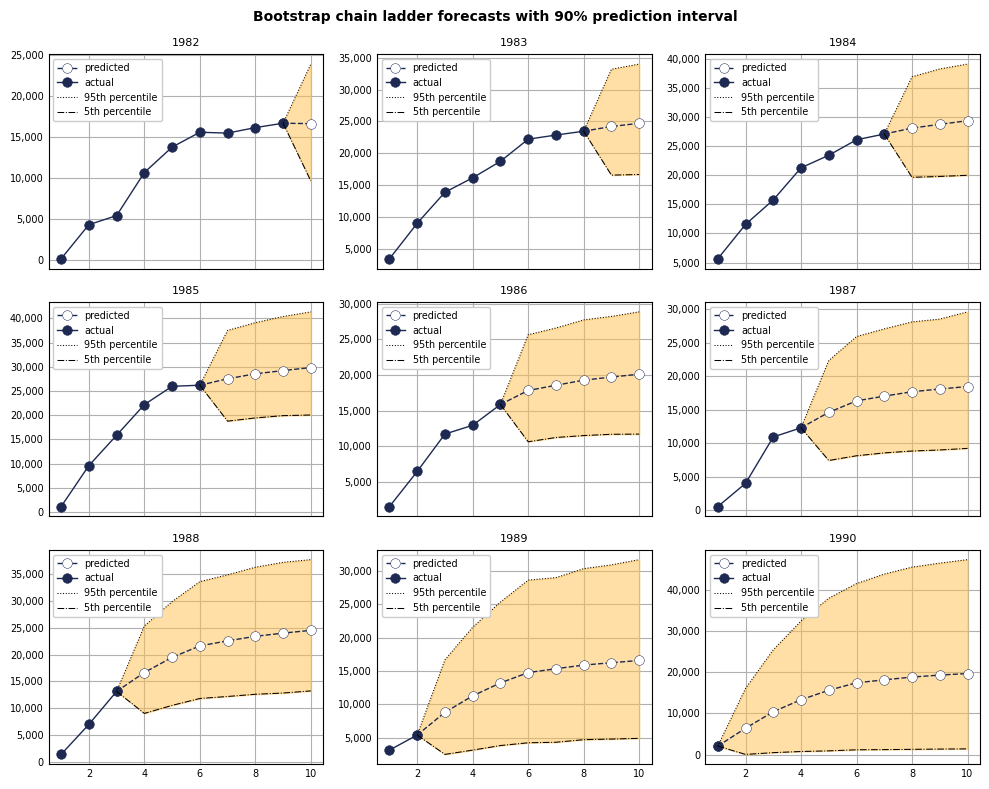

In [24]:

import matplotlib as mpl
from matplotlib.ticker import MaxNLocator


fill_color = "#FFC04C"


# Assume 9 origin periods (no distribution of fully-developed oldest origin period)
indices = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
origin_periods = tri0.index[1:].tolist()

fig, ax = plt.subplots(3, 3, figsize=(10, 8), tight_layout=True, sharex=True) 

for (ii, jj), origin in zip(indices, origin_periods):

    dforigin = df[df.origin==origin]

    ax[ii, jj].set_title(f"{origin}", fontsize=8)

    # Get last actual development period for origin.
    last_actual_devp = dforigin[dforigin.actual_devp_ind==1].dev.max()

    # Actual values.
    act_dev = dforigin[dforigin.actual_devp_ind==1].dev.tolist()
    act_val = dforigin[dforigin.actual_devp_ind==1].value.tolist()

    # Predicted values.
    pred_dev = [last_actual_devp] + dforigin[dforigin.actual_devp_ind==0].dev.tolist()
    pred_val = [act_val[-1]] + dforigin[dforigin.actual_devp_ind==0].value.tolist()

    # 5th and 95th percentiles.
    pred_5th = [act_val[-1]] +  dforigin[dforigin.actual_devp_ind==0].bcl_5th.tolist()
    pred_95th = [act_val[-1]] + dforigin[dforigin.actual_devp_ind==0].bcl_95th.tolist()

    ax[ii, jj].plot(
        pred_dev, pred_val, "o", markersize=7, color="#1d2951", markerfacecolor="#FFFFFF", 
        markeredgecolor="#1d2951", markeredgewidth=.35, linestyle="--", linewidth=1., label="predicted"
    )

    ax[ii, jj].plot(
        act_dev, act_val, "o", markersize=7, color="#1d2951", markerfacecolor="#1d2951", 
         markeredgecolor="#1d2951", markeredgewidth=.35, linestyle="-", linewidth=1., label="actual"
    )

    ax[ii, jj].plot(
        pred_dev, pred_95th, color="#000000", linestyle=":",  # color="#FFFFB2",
        linewidth=.75, label="95th percentile"
    )

    ax[ii, jj].plot(
        pred_dev, pred_5th, color="#000000", linestyle="-.",  # color="#FFFFB2",
        linewidth=.75, label="5th percentile"
    )

    ax[ii, jj].fill_between(pred_dev, pred_5th, pred_95th, color=fill_color, alpha=.50)
    ax[ii, jj].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
    ax[ii, jj].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[ii, jj].tick_params(axis="x", which="major", direction='in', labelsize=7)
    ax[ii, jj].tick_params(axis="y", which="major", direction='in', labelsize=7)
    ax[ii, jj].xaxis.set_ticks_position("none")
    ax[ii, jj].yaxis.set_ticks_position("none")
    ax[ii, jj].grid(True)   
    ax[ii, jj].set_axisbelow(True) 
    ax[ii, jj].legend(loc="upper left", fancybox=True, framealpha=1, fontsize="x-small")

plt.suptitle("Bootstrap chain ladder forecasts with 90% prediction interval", fontsize=10, weight="bold")

plt.show()



<br>

As expected, the prediction intervals grow wider for origin periods with fewer development periods of actual data to account for the greater uncertainty in ultimate projections.

Second, an exhibit with a separate histogram per facet can be used to visualize the distribution of IBNR generated by the bootstrap chain ladder:

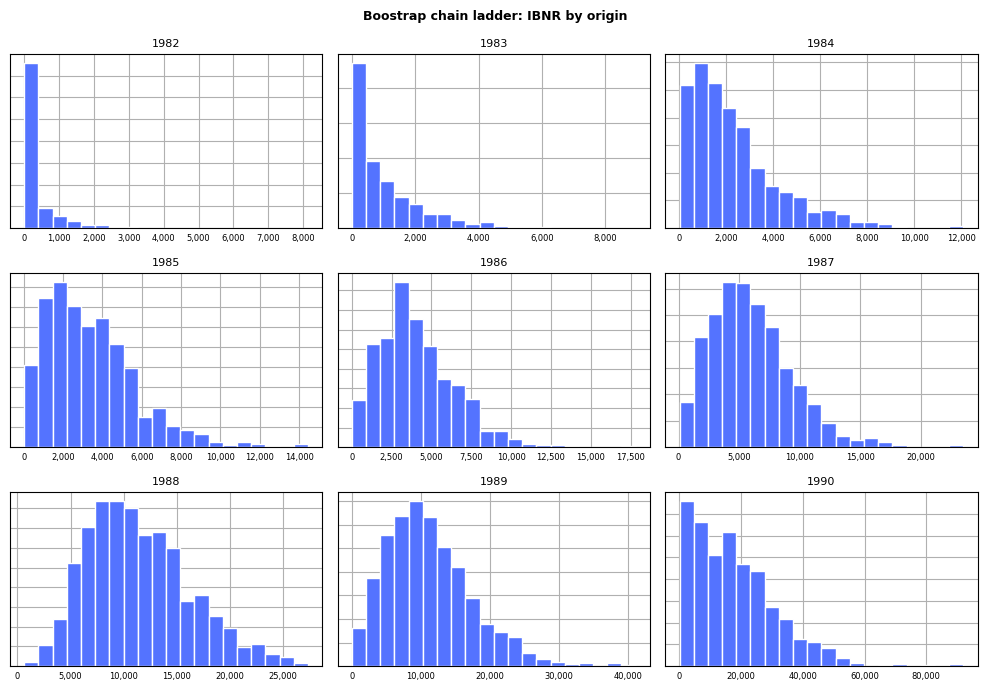

In [25]:

import matplotlib as mpl
import matplotlib.pyplot as plt


# Color for each histogram.
hist_color = "#5473ff"

# Assume 9 origin periods (no distribution of fully-developed oldest origin period)
indices = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
origin_periods = tri0.index[1:].tolist()

fig, ax = plt.subplots(3, 3, figsize=(10, 7), tight_layout=True) 

for (ii, jj), origin in zip(indices, origin_periods):
    ax[ii, jj].set_title(str(origin), fontsize=8, weight="normal")
    ax[ii, jj].hist(
        dfibnr[dfibnr.origin==origin].ibnr, 20, density=True, alpha=1, 
        color=hist_color, edgecolor="#FFFFFF", linewidth=1.0
        )
    
    # ax[ii, jj].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
    ax[ii, jj].set_yticklabels([])
    ax[ii, jj].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
    ax[ii, jj].tick_params(axis="x", which="major", direction='in', labelsize=6)
    ax[ii, jj].tick_params(axis="x", which="minor", direction='in', labelsize=6)
    ax[ii, jj].tick_params(axis="y", which="major", direction='in', labelsize=6)
    ax[ii, jj].tick_params(axis="y", which="minor", direction='in', labelsize=6)
    ax[ii, jj].xaxis.set_ticks_position("none")
    ax[ii, jj].yaxis.set_ticks_position("none")
    ax[ii, jj].grid(True)   
    ax[ii, jj].set_axisbelow(True) 

plt.suptitle("Boostrap chain ladder: IBNR by origin", fontsize=9, weight="bold")
plt.show()



<br>



Finally, we can create a similar exhibit for the aggregate distribution of IBNR, with vertical lines added at the 50th, 75th, 95th and 99th percentile of total needed reserve:

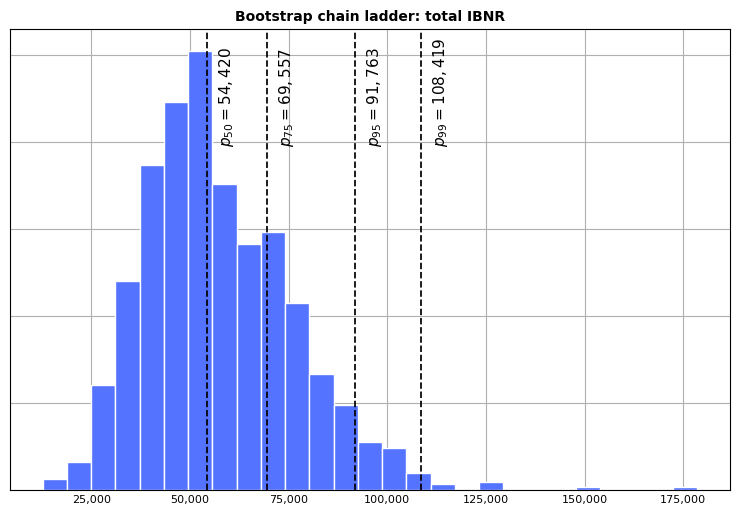

In [26]:

hist_color = "#5473ff"

dfibnr_total = dfibnr.groupby("n", as_index=False)["ibnr"].sum()
ibnr_total = dfibnr_total["ibnr"].values
ibnr_50 = np.quantile(ibnr_total, .50).item()
ibnr_75 = np.quantile(ibnr_total, .75).item()
ibnr_95 = np.quantile(ibnr_total, .95).item()
ibnr_99 = np.quantile(ibnr_total, .99).item()

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.25), tight_layout=True) 

ax.set_title("Bootstrap chain ladder: total IBNR", fontsize=10, weight="bold")

ax.hist(
    ibnr_total, 27, density=True, alpha=1, color=hist_color, 
    edgecolor="#FFFFFF", linewidth=1.0
    )

# 50th percentile.
ax.axvline(ibnr_50, color="#000000", linewidth=1.25, linestyle="--")
ax.annotate(
    r"$p_{{50}} = {:,.0f}$".format(ibnr_50), xycoords="data", xy=(ibnr_50, 2e-5),
    fontsize=11, rotation=90, weight="normal", color="#000000", xytext=(10, 0), 
    textcoords="offset pixels"
)

# 75th percentile.
ax.axvline(ibnr_75, color="#000000", linewidth=1.25, linestyle="--")
ax.annotate(
    r"$p_{{75}} = {:,.0f}$".format(ibnr_75), xycoords="data", xy=(ibnr_75, 2e-5),
    fontsize=11, rotation=90, weight="normal", color="#000000", xytext=(10, 0), 
    textcoords="offset pixels"
)

# 95th percentile.
ax.axvline(ibnr_95, color="#000000", linewidth=1.25, linestyle="--")
ax.annotate(
    r"$p_{{95}} = {:,.0f}$".format(ibnr_95), xycoords="data", xy=(ibnr_95, 2e-5),
    fontsize=11, rotation=90, weight="normal", color="#000000", xytext=(10, 0), 
    textcoords="offset pixels"
)

# 99th percentile.
ax.axvline(ibnr_99, color="#000000", linewidth=1.25, linestyle="--")
ax.annotate(
    r"$p_{{99}} = {:,.0f}$".format(ibnr_99), xycoords="data", xy=(ibnr_99, 2e-5),
    fontsize=11, rotation=90, weight="normal", color="#000000", xytext=(10, 0), 
    textcoords="offset pixels"
)

# ax[ii, jj].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_yticklabels([])
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.tick_params(axis="x", which="major", direction='in', labelsize=8)
# ax.tick_params(axis="x", which="minor", direction='in', labelsize=8)
ax.tick_params(axis="y", which="major", direction='in', labelsize=8)
# ax.tick_params(axis="y", which="minor", direction='in', labelsize=8)
ax.xaxis.set_ticks_position("none")
ax.yaxis.set_ticks_position("none")
ax.grid(True)   
ax.set_axisbelow(True) 
plt.show()



<br>

Existing third-party Python libraries such as [trikit](https://trikit.github.io/trikit-docs/quickstart.html) expose a number of models that can be used to estimate outstanding claim liabilities, but it can be helpful to see in detail how these estimates are obtained. Other loss reserving techniques will be explored in future posts. 